<a href="https://www.kaggle.com/code/danggcc/notebook12b342e4ba?scriptVersionId=187205720" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
from pathlib import Path
import os
from random import randint
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Tensorflow and Keras
from keras import models
from keras.layers import Conv2D, Dense,MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D
import keras.preprocessing  as kp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint

from keras.datasets import cifar10
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

2024-07-07 10:59:57.664649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 10:59:57.664776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 10:59:57.766340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Đường dẫn tới tập huấn luyện, kiểm tra và kiểm tra
train_path = '/kaggle/input/malware/malimg_dataset/train'
valid_path = '/kaggle/input/malware/malimg_dataset/validation'
test_path = '/kaggle/input/malwaretest/test'

# Tạo các đối tượng ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=[0.8, 1.2],
    channel_shift_range=50.0
)

valid_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Tạo các DataFrame từ các ImageDataGenerator với đường dẫn đúng
train_df = train_datagen.flow_from_directory(directory=train_path, 
                                             target_size=(256, 256), 
                                             batch_size=32, 
                                             class_mode='categorical', 
                                             color_mode="rgb")

valid_df = valid_test_datagen.flow_from_directory(directory=valid_path, 
                                                  target_size=(256, 256), 
                                                  batch_size=32, 
                                                  class_mode='categorical', 
                                                  color_mode="rgb")

test_df = valid_test_datagen.flow_from_directory(directory=test_path, 
                                                 target_size=(256, 256), 
                                                 batch_size=32, 
                                                 class_mode='categorical', 
                                                 color_mode="rgb",
                                                 shuffle=False)


Found 8404 images belonging to 25 classes.
Found 935 images belonging to 25 classes.
Found 175 images belonging to 25 classes.


In [3]:
# get images and label of images from training dataset use for display some of dataset.
imgs, labels = next(train_df)

In [4]:
# create label dictionary to use it know the type of malware (model use index(number not text))
label_dict = {value:key for key, value in train_df.class_indices.items()}
print(label_dict)

{0: 'Adialer.C', 1: 'Agent.FYI', 2: 'Allaple.A', 3: 'Allaple.L', 4: 'Alueron.gen!J', 5: 'Autorun.K', 6: 'C2LOP.P', 7: 'C2LOP.gen!g', 8: 'Dialplatform.B', 9: 'Dontovo.A', 10: 'Fakerean', 11: 'Instantaccess', 12: 'Lolyda.AA1', 13: 'Lolyda.AA2', 14: 'Lolyda.AA3', 15: 'Lolyda.AT', 16: 'Malex.gen!J', 17: 'Obfuscator.AD', 18: 'Rbot!gen', 19: 'Skintrim.N', 20: 'Swizzor.gen!E', 21: 'Swizzor.gen!I', 22: 'VB.AT', 23: 'Wintrim.BX', 24: 'Yuner.A'}


In [5]:
# Tính toán trọng số cho từng lớp
all_labels = train_df.classes
classes = np.unique(all_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)

{0: 3.4655670103092784, 1: 3.694065934065934, 2: 0.11903682719546742, 3: 0.22545942320590207, 4: 1.943121387283237, 5: 4.150123456790124, 6: 2.7781818181818183, 7: 1.9209142857142858, 8: 2.211578947368421, 9: 2.453722627737226, 10: 1.098562091503268, 11: 0.9442696629213483, 12: 2.197124183006536, 13: 2.114213836477987, 14: 3.430204081632653, 15: 2.5086567164179105, 16: 3.0284684684684686, 17: 2.873162393162393, 18: 2.527518796992481, 19: 6.112, 20: 3.2636893203883495, 21: 3.141682242990654, 22: 0.8777023498694517, 23: 4.668888888888889, 24: 0.4337548387096774}


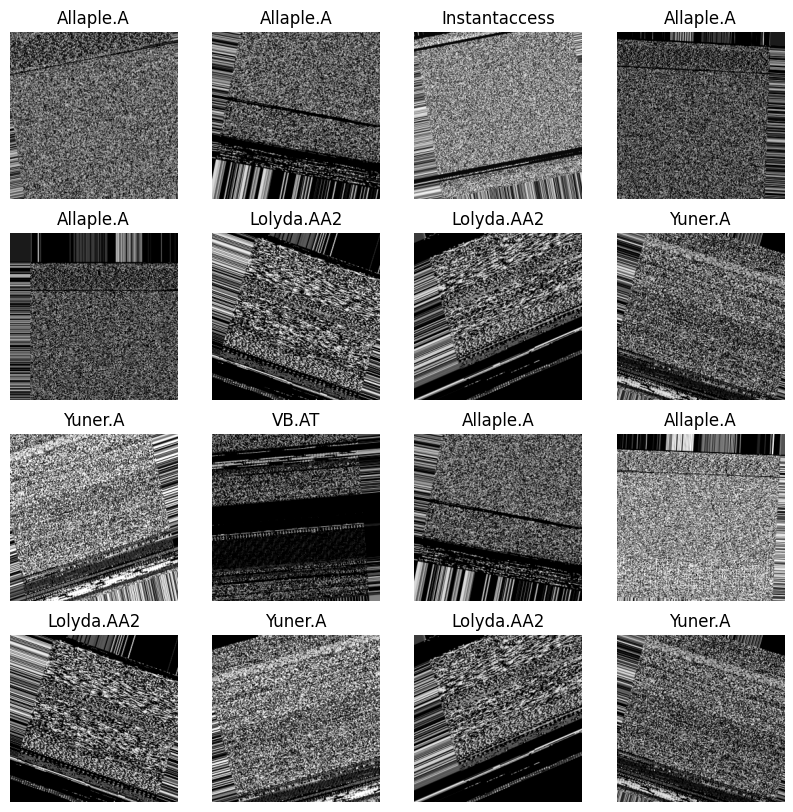

In [6]:
# Create subplot for some sample of train data
fig, ax = plt.subplots(4, 4, figsize=(10, 10))

# Loop on new image predict and display
for row in range(16):
    i = row // 4
    j = row % 4
    rand_index = randint(0, imgs.shape[0] - 1)  # Ensure the index is valid
    ax[i, j].imshow(imgs[rand_index])
    ax[i, j].set_title(label_dict[np.argmax(labels[rand_index])])
    ax[i, j].axis('off')

plt.show()

In [7]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
# Khởi tạo mô hình tiền huấn luyện DenseNet201
path = '/kaggle/input/pretrain/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = DenseNet201(weights=path, include_top=False, input_shape=(256, 256, 3))

# Đóng băng các lớp ban đầu của mô hình DenseNet201
for layer in base_model.layers[:-20]:
    layer.trainable = False

for layer in base_model.layers[-20:]:
    layer.trainable = True

# Tạo mô hình mới với các lớp tùy chỉnh
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(units=512, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(units=256, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(units=25, activation='softmax')(x)

# Kết hợp mô hình cơ bản và các lớp tùy chỉnh
model = Model(inputs=base_model.input, outputs=predictions)


In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Biên dịch mô hình
optimizer = Adam(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)
callbacks = [early_stop, checkpoint, reduce_lr]


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [9]:
# Train the model with class weights
history = model.fit(
    train_df, 
    validation_data=valid_df, 
    epochs=50, 
    callbacks=callbacks, 
    class_weight=class_weights_dict
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/263 ━━━━━━━━━━━━━━━━━━━━ 4:50:53 67s/step - accuracy: 0.0000e+00 - loss: 4.9933

I0000 00:00:1720350087.237223      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.0983 - loss: 5.4313
Epoch 1: val_accuracy improved from -inf to 0.49519, saving model to best_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.0985 - loss: 5.4276 - val_accuracy: 0.4952 - val_loss: 2.8403 - learning_rate: 1.0000e-04
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.3461 - loss: 2.9573
Epoch 2: val_accuracy improved from 0.49519 to 0.61818, saving model to best_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 157s 582ms/step - accuracy: 0.3463 - loss: 2.9563 - val_accuracy: 0.6182 - val_loss: 2.0748 - learning_rate: 1.0000e-04
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.5189 - loss: 2.2396
Epoch 3: val_accuracy did not improve from 0.61818
263/263 ━━━━━━━━━━━━━━━━━━━━ 156s 578ms/step - accuracy: 0.5190 - loss: 2.2391 - val_accuracy: 0.6150 - val_loss: 1.8790 - learning_rate: 1.0000e-04
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.6638 - lo

In [10]:
# Calculate test accuracy and loss
test_loss, test_acc = model.evaluate(test_df)
print('Test Accuracy:', round(test_acc * 100, 2), "%")
print('Test Loss:', test_loss)


6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.9216 - loss: 0.8058
Test Accuracy: 89.14 %
Test Loss: 0.9192003607749939


In [11]:
model.load_weights('./best_model.keras')

In [12]:
imgs, labels = next(test_df)

6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step
Number of correct predictions: 141
Total number of predictions: 175
Accuracy: 0.81


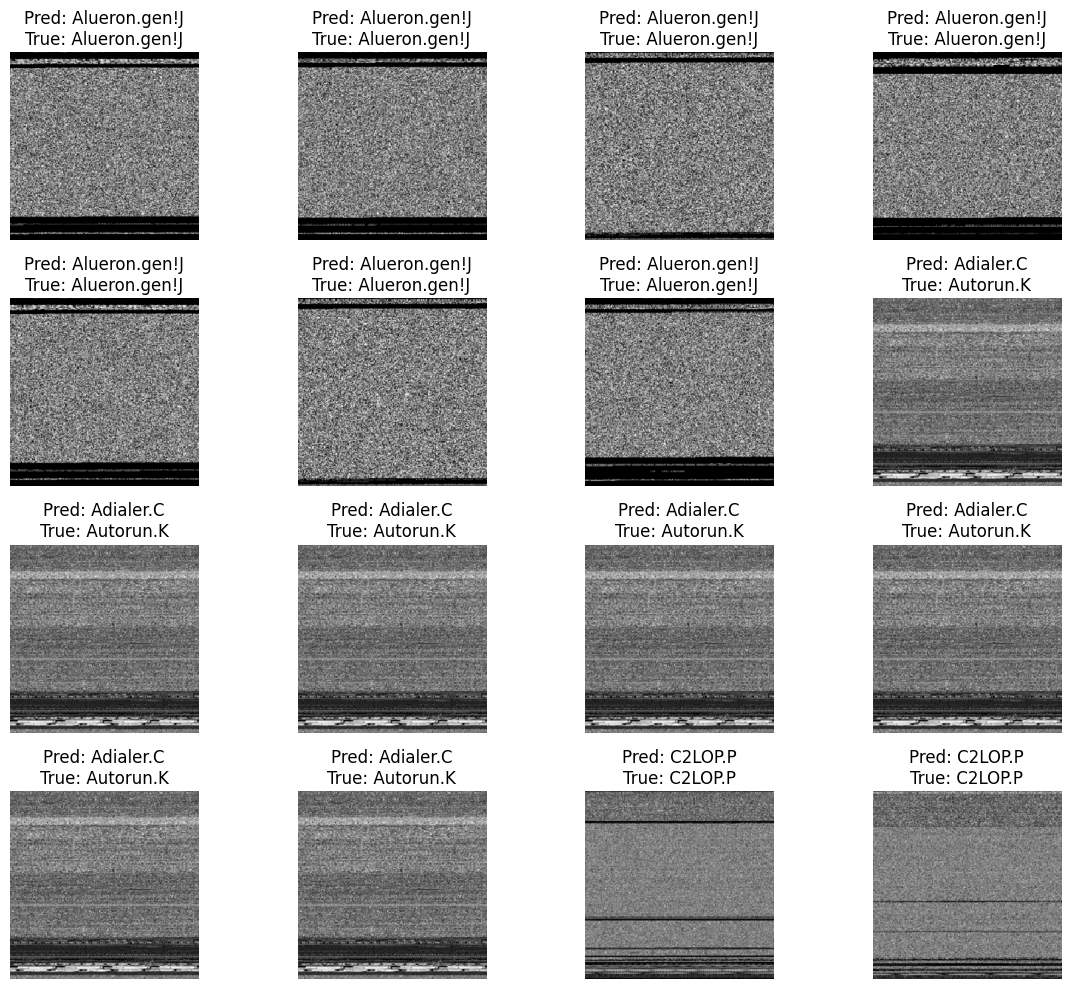

In [13]:
# Lấy toàn bộ ảnh và nhãn từ tập test
all_imgs, all_labels = [], []
for i in range(len(test_df)):
    imgs, labels = next(test_df)
    all_imgs.append(imgs)
    all_labels.append(labels)

# Chuyển đổi danh sách thành numpy array
all_imgs = np.vstack(all_imgs)
all_labels = np.vstack(all_labels)

# Dự đoán nhãn cho tất cả các ảnh trong tập test
predicted_labels = model.predict(all_imgs)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Chuyển nhãn gốc sang chỉ số
true_labels = np.argmax(all_labels, axis=1)

# Tính toán số lượng dự đoán đúng
correct_predictions = np.sum(predicted_labels == true_labels)
total_predictions = len(true_labels)
accuracy = correct_predictions / total_predictions

print(f"Number of correct predictions: {correct_predictions}")
print(f"Total number of predictions: {total_predictions}")
print(f"Accuracy: {accuracy:.2f}")

# Hiển thị một số ảnh cùng với nhãn dự đoán và nhãn gốc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 4, figsize=(12, 10))
for row in range(16):
    i = row // 4
    j = row % 4
    ax[i, j].imshow(all_imgs[row])
    
    # Hiển thị nhãn dự đoán và nhãn gốc
    ax[i, j].set_title(f"Pred: {label_dict[predicted_labels[row]]}\nTrue: {label_dict[true_labels[row]]}")
    ax[i, j].axis('off')

plt.tight_layout()
plt.show()

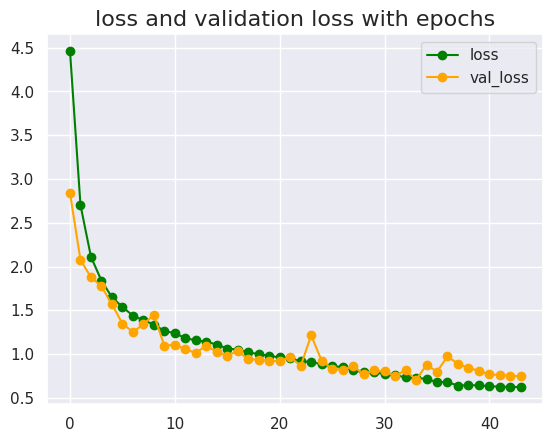

In [14]:
sns.set()
# plot loss function for train and validation.
plt.title('loss and validation loss with epochs', 
          fontsize=16)

plt.plot(history.history['loss'],
         marker='o',
         color="green",
         label="loss")

plt.plot(history.history['val_loss'],
         marker='o',
         color="orange", 
         label="val_loss")

plt.legend()
plt.show()


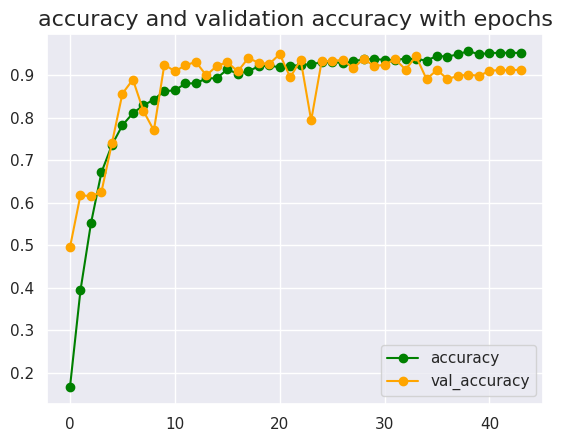

In [15]:
# plot accuracy for train and validation data.
plt.title('accuracy and validation accuracy with epochs',
          fontsize=16)

plt.plot(history.history['accuracy'],
         marker='o',
         color="green",
         label="accuracy")

plt.plot(history.history['val_accuracy'],
         marker='o',
         color="orange",
         label="val_accuracy")

plt.legend()
plt.show()

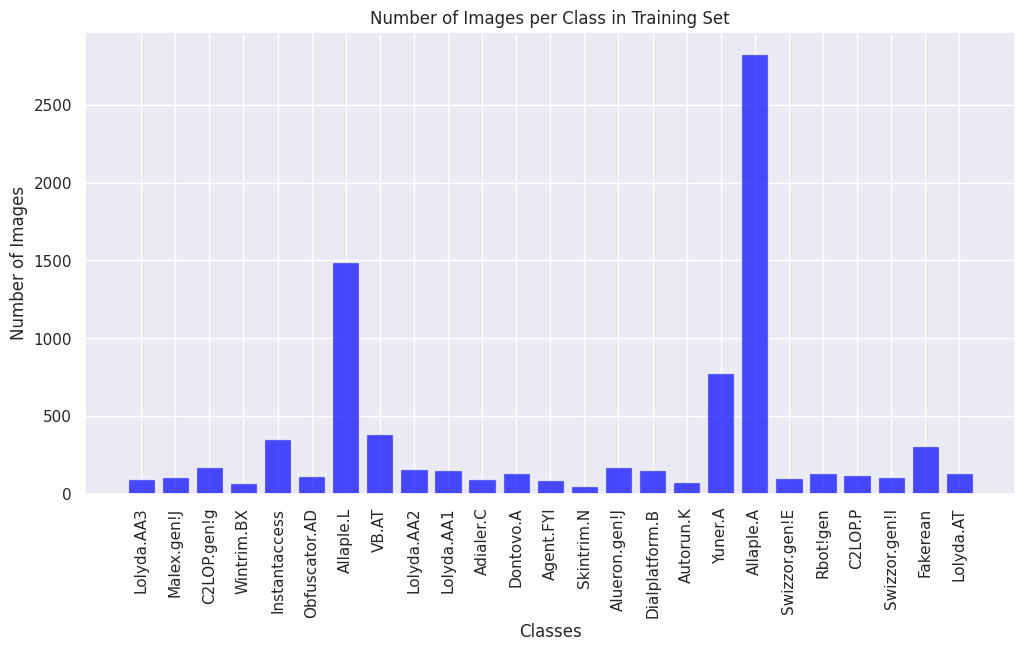

In [16]:
import os
import matplotlib.pyplot as plt

# Đường dẫn tới thư mục huấn luyện
train_dir = '/kaggle/input/malware/malimg_dataset/train'

# Hàm đếm số lượng ảnh trong mỗi lớp
def count_images_in_directory(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

# Đếm số lượng ảnh trong mỗi lớp cho tập huấn luyện
train_counts = count_images_in_directory(train_dir)

# Hàm vẽ biểu đồ cột so sánh số lượng ảnh trong mỗi lớp
def plot_class_distribution(class_counts):
    labels = list(class_counts.keys())
    values = list(class_counts.values())

    x = range(len(labels))

    plt.figure(figsize=(12, 6))
    plt.bar(x, values, align='center', alpha=0.7, color='blue')

    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class in Training Set')
    plt.xticks(x, labels, rotation='vertical')
    plt.show()

# Gọi hàm để vẽ biểu đồ
plot_class_distribution(train_counts)


6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step


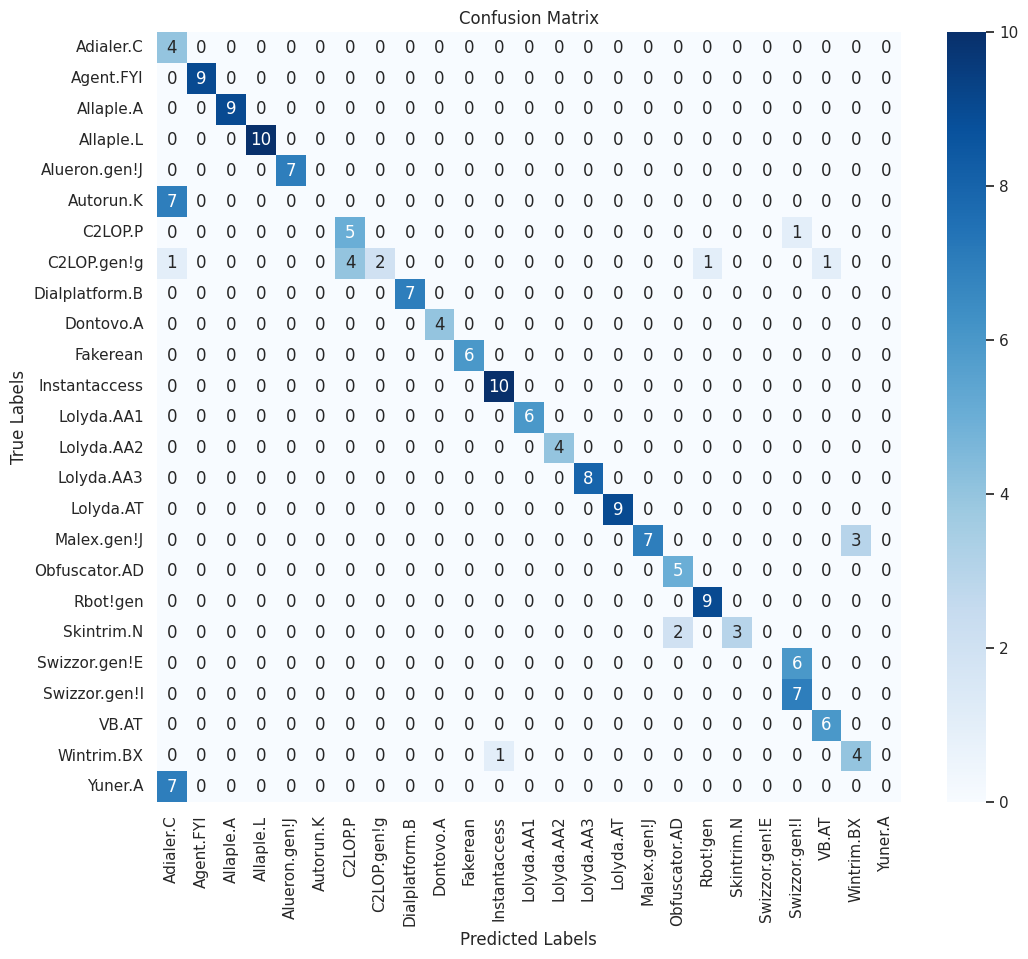

                precision    recall  f1-score   support

     Adialer.C       0.21      1.00      0.35         4
     Agent.FYI       1.00      1.00      1.00         9
     Allaple.A       1.00      1.00      1.00         9
     Allaple.L       1.00      1.00      1.00        10
 Alueron.gen!J       1.00      1.00      1.00         7
     Autorun.K       0.00      0.00      0.00         7
       C2LOP.P       0.56      0.83      0.67         6
   C2LOP.gen!g       1.00      0.22      0.36         9
Dialplatform.B       1.00      1.00      1.00         7
     Dontovo.A       1.00      1.00      1.00         4
      Fakerean       1.00      1.00      1.00         6
 Instantaccess       0.91      1.00      0.95        10
    Lolyda.AA1       1.00      1.00      1.00         6
    Lolyda.AA2       1.00      1.00      1.00         4
    Lolyda.AA3       1.00      1.00      1.00         8
     Lolyda.AT       1.00      1.00      1.00         9
   Malex.gen!J       1.00      0.70      0.82  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Dự đoán trên tập kiểm tra
test_df.reset()  # Đảm bảo rằng các chỉ số của hình ảnh trong tập kiểm tra được đặt lại
predictions = model.predict(test_df, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_df.classes

# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(true_classes, predicted_classes)
class_labels = list(test_df.class_indices.keys())  # Lấy nhãn lớp từ chỉ số lớp

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Báo cáo phân loại
print(classification_report(true_classes, predicted_classes, target_names=class_labels))